In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X_test = data['cleaned_text']
y_test = data['mental_health_issue']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_lr = lr_vectorizer.transform(X_test)
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)
nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)

# Define weights for models (based on prior performance or experimentation)
weights = {
    'lr': 0.25,  # Logistic Regression
    'svm': 0.2,  # SVM
    'nb': 0.15,  # Naive Bayes
    'xgb': 0.25, # XGBoost
    'lstm': 0.15 # LSTM
}

# Weighted sum of probabilities
final_predictions_proba = (
    weights['lr'] * lr_predictions_proba +
    weights['svm'] * svm_predictions_proba +
    weights['nb'] * nb_predictions_proba +
    weights['xgb'] * xgb_predictions_proba +
    weights['lstm'] * lstm_predictions_proba
)

# Final predictions based on maximum weighted probability
final_predictions = np.argmax(final_predictions_proba, axis=1)

# Evaluate weighted voting ensemble
accuracy = accuracy_score(y_test, final_predictions)
report = classification_report(y_test, final_predictions, target_names=label_encoder.classes_)

print(f"Weighted Voting Ensemble Accuracy: {accuracy * 100:.2f}%")
print("Classification Report (Weighted Voting):\n", report)
print("Confusion Matrix:\n", confusion_matrix(y_test, final_predictions))


581/581 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step
Weighted Voting Ensemble Accuracy: 94.93%
Classification Report (Weighted Voting):
               precision    recall  f1-score   support

     anxiety       0.95      0.92      0.93      1999
     bipolar       0.94      0.75      0.84      1941
  depression       0.92      0.94      0.93      1959
      normal       0.95      1.00      0.97     10679
        ptsd       0.98      0.91      0.94      1987

    accuracy                           0.95     18565
   macro avg       0.95      0.91      0.92     18565
weighted avg       0.95      0.95      0.95     18565

Confusion Matrix:
 [[ 1843    28    53    64    11]
 [   10  1464    52   406     9]
 [   40    28  1843    36    12]
 [    4     5     2 10666     2]
 [   47    29    54    49  1808]]


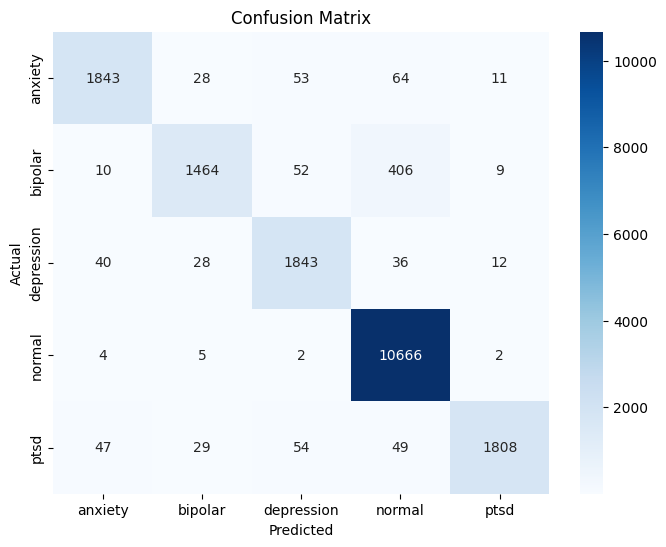

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


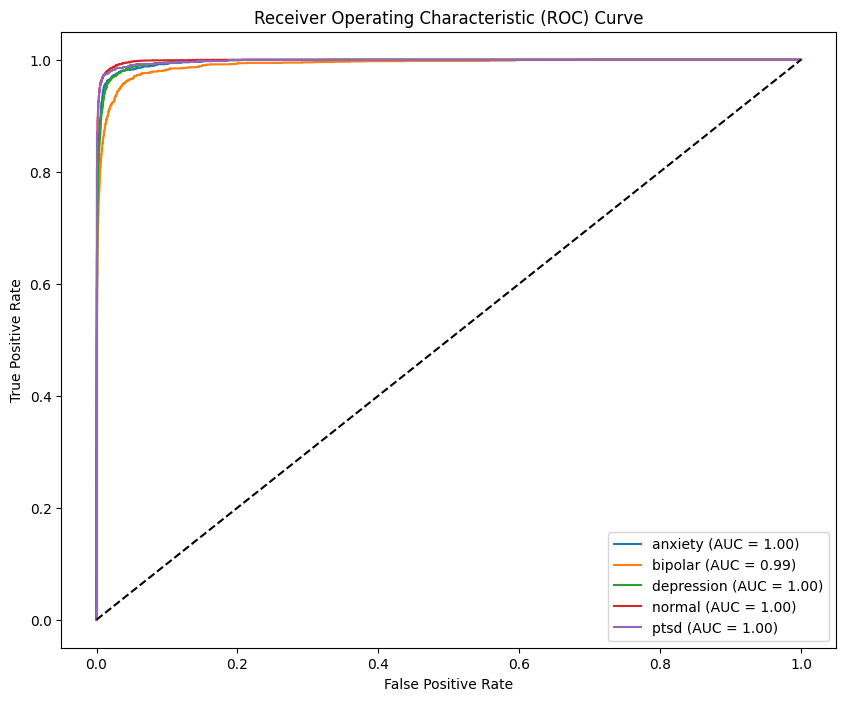

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))

# Calculate ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], final_predictions_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
